In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [9]:
class ok():
    
    def __init__(self):
        self.b =5
        def s(x,y):
            return x+y+self.b
        
        self.s = s
        
        
o = ok()        

In [12]:
o.s(1,2)

6

In [11]:
o.b=3

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
import lfp
arm = 'UR5'

TEST_DATASET = "UR5_slow_gripper_test" 
print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["UR5", "UR5_high_transition", "UR5_slow_gripper"]]
TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


Using local setup
Working path: /home/sholto/Desktop/AI/learning_from_play
Storage path: /home/sholto/Desktop/AI/learning_from_play


In [2]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# 
RELATIVE = False # use relative joints instead of absolute pos/ori as in the original paper
QUAT =  False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = False
USE_QUAT_OBS = False

LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 5.0
GCBC = False
PROBABILISTIC = False
QUANTISED = False
PROPRIOCEPTION = False
arm = 'UR5'



In [4]:
path = "saved_models/ALLB0.00003_60k"
hyper_params = np.load(f'{path}/hyper_params.npz', allow_pickle=True)
scaling = hyper_params['scaling']
for k,v in hyper_params.items():
    print(k,v)

means_obs None
stds_obs None
means_goals None
stds_goals None
RELATIVE False
QUAT False
JOINTS False
VELOCITY False
USE_QUAT_OBS False
USE_QUAT_AUGMENTATION False
LAYER_SIZE 2048
LATENT_DIM 256
GRIPPER_WEIGHT 1.0
GCBC False
PROBABILISTIC False
arm UR5
QUANTISED False
scaling None
run_id 12621l2h


In [8]:
dl = lfp.data.PlayDataloader(batch_size=32)
valid_data = dl.extract([TEST_DATA_PATH])

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 96.06it/s]


In [9]:

valid_dataset = dl.load(valid_data)

{   'acts': TensorSpec(shape=(32, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(32, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(32,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None)}


In [8]:
#dataset = dataloader.extract([TEST_DATA_PATH])
import seaborn as sns
for i in range(0,valid_data['achieved_goals'].shape[1]):
    sns.distplot(valid_data['achieved_goals'][:,i], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    plt.show()

TypeError: 'TensorSliceDataset' object is not subscriptable

In [9]:
iter(valid_dataset).next()

{'obs': <tf.Tensor: shape=(32, 50, 18), dtype=float32, numpy=
 array([[[-0.00859262,  0.05601606,  0.15802324, ..., -0.07926399,
           0.03      ,  0.        ],
         [-0.00630781,  0.06365258,  0.14609186, ..., -0.07926399,
           0.03      ,  0.        ],
         [-0.00377585,  0.07336631,  0.12936227, ..., -0.07926399,
           0.03      ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ..., -0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ..., -0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ..., -0.        ,
           0.        ,  0.        ]],
 
        [[ 0.22766858,  0.18562245,  0.07474581, ..., -0.07314114,
           0.03      ,  0.7877586 ],
         [ 0.2277864 ,  0.19797134,  0.05359903, ..., -0.07314114,
           0.03      ,  0.7877586 ],
         [ 0.22752768,  0.20774685,  0.03863379, ..., -0.07314114,
           0.03      ,

In [10]:
print(f'Obs: (N,{dl.obs_dim}), Acts: (N,{dl.act_dim}), Goals: (N,{dl.goal_dim})')

Obs: (N,18), Acts: (N,7), Goals: (N,11)


# Load our  models

In [11]:
model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'latent_dim':LATENT_DIM}

actor = lfp.model.create_actor(layer_size=LAYER_SIZE, gcbc=GCBC, num_distribs=None, **model_params)

if GCBC:
    encoder = None
    planner = None
else:
    encoder = lfp.model.create_encoder(layer_size=LAYER_SIZE//4, **model_params)
    planner = lfp.model.create_planner(layer_size=LAYER_SIZE//4, **model_params)

In [12]:
#path = 'NB0.00001' #ABS_RPY_GCBC_UR5 #ABS_RPY_GCBC_2hrs
#path = ''REL_RPY_GCBC_UR5v2' 
#path = 'NB0.000003_0.000006'
def load_weights(path, actor, encoder=None, planner = None, step=""):
    actor.load_weights(f'{path}/model'+step+'.h5')
    if planner is not None: planner.load_weights(f'{path}/planner'+step+'.h5')
    if encoder is not None: encoder.load_weights(f'{path}/encoder'+step+'.h5')
        
        
load_weights(path, actor, encoder, planner)

In [13]:
v_it = iter(valid_dataset)
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
T = states.shape[1]
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, T, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, T, 1))
  pred_acts = actor([states, z, goals]) 

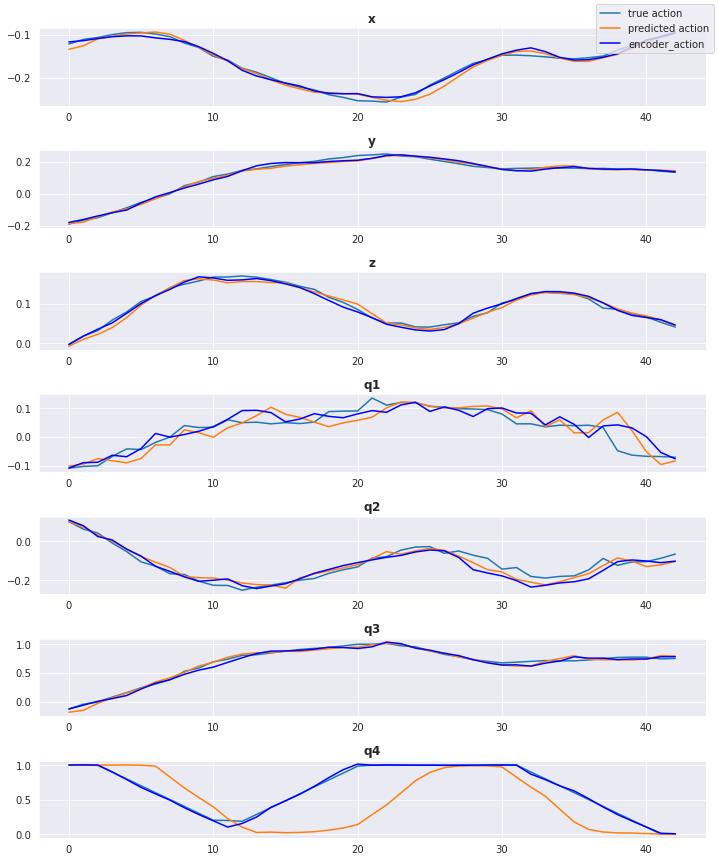

In [16]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 28
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


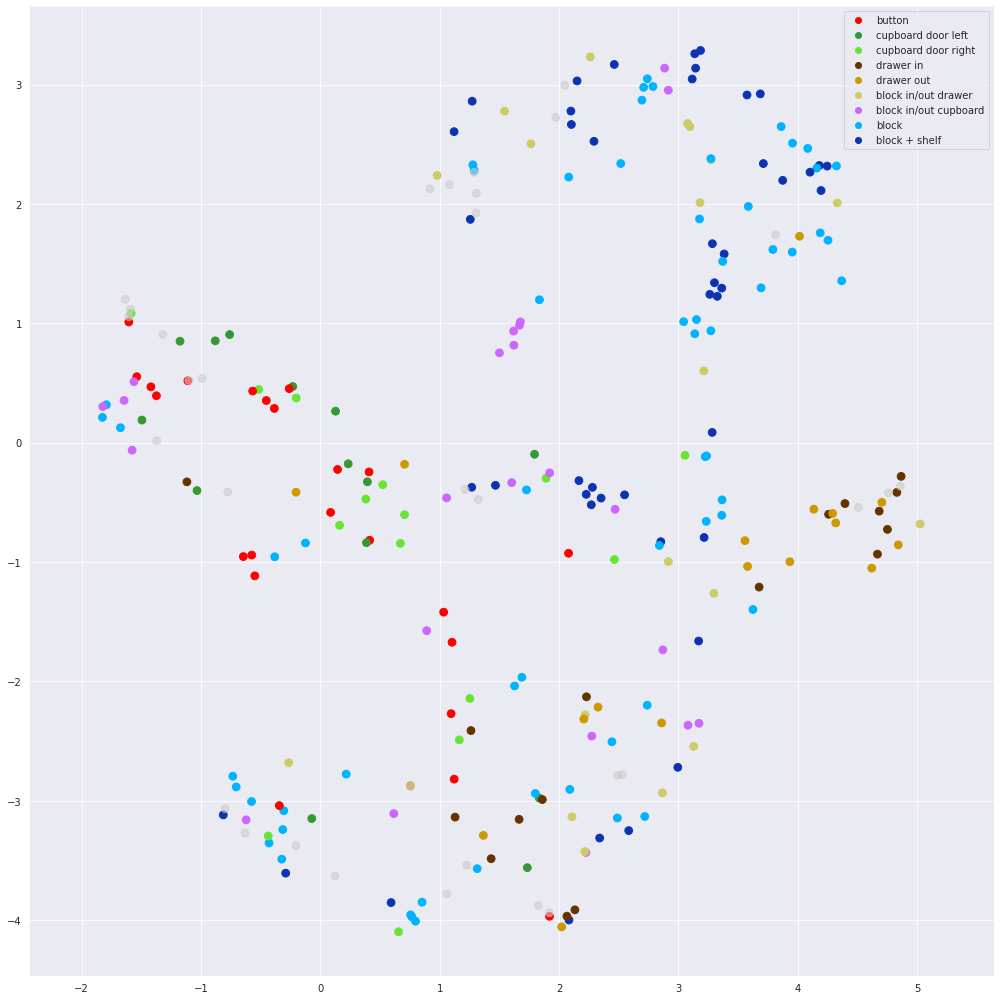

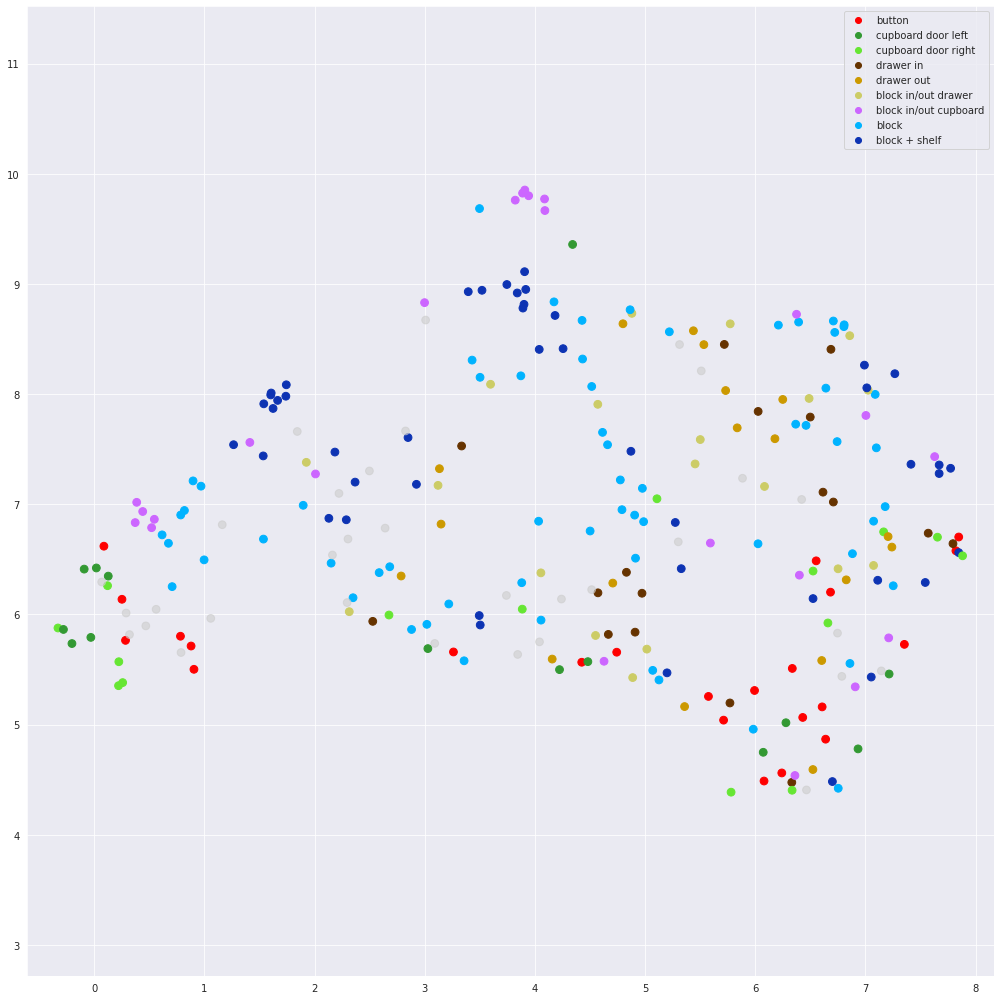

In [19]:
from lfp.plotting import produce_cluster_fig

batch = iter(valid_dataset).next()
_ = produce_cluster_fig(batch, encoder, planner, TEST_DATA_PATH, num_take=dl.batch_size)

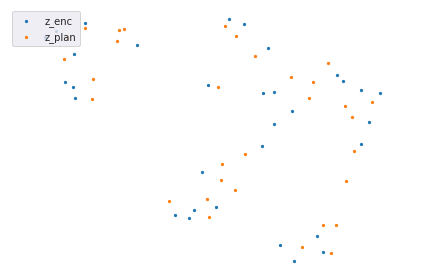

In [20]:
from lfp.plotting import project_enc_and_plan

o = project_enc_and_plan(encoding.sample(), plan.sample(), connecting_lines=False)

In [21]:
#env.panda.close()


In [23]:
import gym
import time
import seaborn as sns

import pandaRL

JOINTS, QUAT, RELATIVE = dl.joints, dl.quaternion_act, dl.relative_act

if arm == 'UR5':
    if JOINTS and RELATIVE:
        env = gym.make('UR5PlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('UR5PlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('UR5PlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('UR5PlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('UR5PlayAbsRPY1Obj-v0')
    else:
        env = gym.make('UR5Play1Obj-v0')
else:
    if JOINTS and RELATIVE:
        env = gym.make('pandaPlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('pandaPlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('pandaPlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('pandaPlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('pandaPlayAbsRPY1Obj-v0')
    else:
        env = gym.make('pandaPlay1Obj-v0')
        
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs
current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN',

/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


{'observation': array([ 1.72024276e-02,  1.08129345e-01,  2.63655603e-01,  3.67674249e-04,
         2.80494126e-03,  4.19891148e-04,  9.99995887e-01, -1.39885495e-04,
         1.43480659e-01,  1.34513676e-01,  4.94896155e-03,  3.25866145e-14,
         2.18210392e-14,  7.07106769e-01,  7.07106769e-01,  7.28993414e-17,
         0.00000000e+00,  1.12222219e-02,  0.00000000e+00], dtype=float32),
 'achieved_goal': array([1.4348066e-01, 1.3451368e-01, 4.9489615e-03, 3.2586614e-14,
        2.1821039e-14, 7.0710677e-01, 7.0710677e-01, 7.2899341e-17,
        0.0000000e+00, 1.1222222e-02, 0.0000000e+00], dtype=float32),
 'desired_goal': array([-0.09496046,  0.03910001,  0.06227459], dtype=float32),
 'controllable_achieved_goal': array([ 1.72024276e-02,  1.08129345e-01,  2.63655603e-01, -1.39885495e-04],
       dtype=float32),
 'full_positional_state': array([ 1.72024276e-02,  1.08129345e-01,  2.63655603e-01,  3.67674249e-04,
         2.80494126e-03,  4.19891148e-04,  9.99995887e-01, -1.39885495e

In [24]:

    
    
model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'latent_dim':LATENT_DIM,
                'training':False, 'return_state':True}

actor = lfp.model.create_actor(layer_size=LAYER_SIZE, gcbc=GCBC, num_distribs=None, **model_params)


In [33]:
def compare_xyz(g, ag, limits = np.array([0.05, 0.05, 0.05])):
    if (abs(g-ag) > limits).any():
        #print('Failed xyz')
        return False
    else:
        return True
    
    
def compare_RPY(g, ag, env, limits = np.array([np.pi/4,np.pi/4,np.pi/4])):
    g = np.array(env.p.getEulerFromQuaternion(g))
    ag = np.array(env.p.getEulerFromQuaternion(ag))
    if (abs(g-ag) > limits).any():
        #print('Failed rpy')
        return False
    else:
        return True
    
def compare_drawer(g, ag, limit=0.025):
    if abs(g-ag) > limit:
        #print('Failed drawer')
        return False
    else:
        return True
    
def compare_door(g, ag, limit=0.03):
    if abs(g-ag) > 0.04:
        #print('Failed door', g, ag)
        return False
    else:
        return True
    
    
def compare_button(g, ag, limit=0.01):
    if abs(g-ag) >limit: 
        #print('Failed button', g , ag)
        return False
    else:
        return True
    
def compare_dial(g,ag, limit=0.3):
    if abs(g-ag) > limit:
        #print('Failed dial')
        return False
    else:
        return True
    
    
def success_func(g, ag):
    g,ag = np.squeeze(g), np.squeeze(ag)
    if compare_xyz(g[0:3], ag[0:3]) and compare_RPY(g[3:7], ag[3:7], env) and compare_drawer(g[7], ag[7]) and compare_door(g[8], ag[8]) and compare_dial(g[10], ag[10]) and compare_button(g[9], ag[9]):
        return True
    else:
        return False

In [34]:
import time

from lfp.plotting import get_labelled_trajs

def clip_action(a):
    #a[0:7] = np.clip(a[0:7], -0.05, 0.05)
    return a

def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(str(TEST_DIR/'states_and_ims'/str(f)/'env_states/*.bullet'))
    print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts_quat'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
def warm_up(actor, o , goal, z = None):
    for i in range(0,10):
            if GCBC:
                a,_,state = actor((o, goal))
            else:
                a = actor((o, z,goal))
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs_quat'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''
    if USE_QUAT_OBS:
        o = obs_dict['observation']
    else:
        o = obs_dict['obs_rpy']
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(obs_dict['velocity'],tf.float32),0),0)], axis = -1)
    if PROPRIOCEPTION:
         
         o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast([obs_dict['gripper_proprioception']],tf.float32),0),0)], axis = -1)
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o

def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_TEST_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(TEST_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.panda.calc_state()
    #print(state['achieved_goal'] - goal)
    #print(goal.shape, a_true.shape, o_true.shape, traj_len)
    return goal, a_true, o_true, traj_len, state



def choose_action(actor, o, z, goal, states=None, a_pred=None, a_true=None, replay=False, i=0):
    if GCBC:
        a,_,state = actor((o, goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
        if states is not None:
            states.append(state)
        if a_pred is not None:
            a_pred.append(a)
        pass
    else:
        
        a,_,state = actor((o, z,goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
            
        if a_pred is not None:
            a_pred.append(a)

    if replay or i < 0: # the less than is just so we can set it so the first n are from demonstration- to check if the init is the issue
        a=a_true[i, :] 
    return a

def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None):
    
    a_pred = []
    states = []
    record_o_buff = []
    
    state = env.panda.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    
    for j in range(0,retries):
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            g = goal['func'](*goal['args'])
            env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if GCBC:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len

        #warm_up(actor, o, g, z)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if success_func(g, ag):
                success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)),success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), success


def test_random_subseq(data, idx, retries = 1, replay=False, replan_horizon=30):
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    a_true, a_pred, states, o_true, record_o_buff, _ = rollout_subseq(goal, retries , replan_horizon, a_true, o_true, traj_len, replay)
    return a_true, a_pred, states, o_true, record_o_buff


##############################################################################
def get_x_of_seq_type(lbl, n = 'all'):
    o, a ,g ,labels, colors, paths = get_labelled_trajs(TEST_DATA_PATH)
    idxs = [ i for i,x in enumerate(labels) if x == lbl]
    print(f"There are {len(idxs)} examples of '{lbl}'")
    if n == 'all':
        return o, a ,g ,labels, colors, paths, idxs
    elif n == 'random':
        idx = np.random.choice(idxs)
        return o, a ,g ,labels, colors, paths, [idx]
    else:
        idx = idxs[n]
        return o, a ,g ,labels, colors, paths, [idx]

def initialise_seq_type(g, paths, idx):

    try:
        env.delete_sub_goal()
    except:
        pass
    print(paths[idx])
    env.p.restoreState(fileName=str(paths[idx]))
    
    env.visualise_sub_goal(g[idx], 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(g[idx], 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    

    return goal

def test_seq_type(data, retries = 1, replay=False, replan_horizon=30):
    o, a ,g ,labels, colors, paths, idxs = data
    
    for idx in idxs:
        goal = initialise_seq_type(g, paths, idx)
        a_true, o_true, traj_len = a[idx], o[idx], len(a[idx])
        
        a_true, a_pred, states, o_true, record_o_buff,_ = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
    return a_true, a_pred, states, o_true, record_o_buff




#########################################

def record_state(path):
    t_step = len(list(os.listdir(path)))
    env.p.saveBullet(path +'/'+ str(t_step)) 
    
    

In [29]:
#path = 'NB0.000006'

In [30]:
#path = 'NB0.00001' 

In [31]:
#path = 'PRORPIO_B0.00003'

In [26]:
load_weights(path, actor, encoder, planner)

In [37]:
lbl = 'stand up block'
data = get_x_of_seq_type(lbl, n = 'all') # all, random or n

There are 21 examples of 'stand up block'


In [38]:
true, pred, states,o_true, o_actual, success = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/420.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5760.bullet


KeyboardInterrupt: 

In [39]:
true, pred, states,o_true, o_actual, success = test_seq_type(data, retries = 10, replay=False, replan_horizon=10)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/420.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5760.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/810.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/2370.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3060.bullet


KeyboardInterrupt: 

In [27]:
[k for k,v in colors_dict.items()]

NameError: name 'colors_dict' is not defined

In [35]:
block = [0,3]
qqqq = [3,7]
drawer = 7
door = 8
button = 9
dial = 10

door_positions = {'left': -0.15, 'middle': 0.0, 'right': 0.15}

drawer_positions = {'closed': 0.075, 'middle': 0.035, 'open': -0.05}

button_positions = {'open': 0.029, 'closed': -0.029}

dial_positions = {'one':0, 'default': 0.35, 'two': 0.8}

obj_poses = {'default': [0,0.1,0.0], 'shelf':[0,0.43, 0.27],
             'left':[-0.2, 0.2,0.0], 'right':[0.2,0.2,0.0],
             'closed_drawer': [-0.15, 0.1, -0.07], 
             'open_drawer':[-0.15, -0.1, -0.07], 
             'cupboard_left': [-0.2, 0.45, 0.0], 
             'cupboard_right':[0.2, 0.45, 0.0]}

obj_oris = {'upright': [0, -0.7,0,0.7], 'default':[0,0,0,1], 
            'lengthways':[0.0, 0.0, 0.7071, 0.7071]}


In [36]:
def current_ag():
    return env.panda.calc_state()['achieved_goal']

def make_goal(obj, pos=None, ori=None):
    '''
    Ori only applies for the block
    '''
    g = current_ag()
    if isinstance(obj,list):
        if pos is not None:
            g[block[0]:block[1]] = np.array(pos)
        if ori is not None:
            g[qqqq[0]:qqqq[1]] = np.array(obj_oris[ori])
            if ori == 'upright' and pos is not None:
                g[2] += 0.025
            
    else:
        g[obj] = pos
        
    return tf.expand_dims(tf.expand_dims(g,0),0)
    

In [37]:
args = (door, door_positions['right'])
args = (door, door_positions['left'])
# args = (drawer, drawer_positions['closed'])
# args = (drawer, drawer_positions['open'])
# args = (button, button_positions['closed'])
# args = (block, obj_poses['left'])
args = (block, obj_poses['shelf'])

tasks = {
    'block_left': (block, obj_poses['left']),
    'block_right': (block, obj_poses['right']),
    'block_shelf': (block, obj_poses['shelf']),
    'block_cupboard_right': (block, obj_poses['cupboard_right']),
    'block_cupboard_left': (block, obj_poses['cupboard_left']),
    'block_drawer':  (block, obj_poses['open_drawer']),
    'block_upright': (block,obj_poses['default'], 'upright'),
    'block_lengthways': (block, obj_poses['default'], 'lengthways'),
    'block_ori_default': (block, obj_poses['default'], 'default'),
    'button': (button, button_positions['closed']),
    'door_left': (door, door_positions['left']),
    'door_right': (door, door_positions['right']),
    'open_drawer': (drawer, drawer_positions['open']),
    'close_drawer': (drawer, drawer_positions['closed']),
    'dial_on': (dial, dial_positions['one']),
    'dial_off': (dial, dial_positions['two']),
}

In [38]:
kwargs = {'goal':{'func':make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None}

In [39]:
task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

KeyboardInterrupt: 

In [47]:
record_path = os.getcwd() + '/recordings/'

def make_recording_dir():
    demo_count = len(list(os.listdir(record_path)))
    example_path = record_path + str(demo_count)
    os.makedirs(example_path)
    return example_path

In [48]:

#env.render('playback')

'/home/sholto/Desktop/AI/learning_from_play/recordings/'

In [73]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
        predicted_actions.append(a_pred)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
        if successes <= 10:
            shutil.rmtree(path)
    except:
        pass
    


8
4
11
5
4
11
11
11
6
4
6
2
7
4
9
11
2
6
2
6
11
11
12
12
10
5
11
7
4
7
8
6
4
11
5
12
12
11
7
6
11
9
11
11
6
12
9
4
6
6
4
4
6
6
0
7
0
11
11
11
3
2
8
11
7
11
12
4
11


KeyboardInterrupt: 

In [90]:
def remove_files(path,x1,x2):
    for step in range(x1,x2):
        os.remove(path+'/'+str(step))
        
        
def reset_from_last(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    env.p.restoreState(fileName = states[-1])

In [106]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    total_steps = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        loop = 1
        while loop:
            _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
            loop = int(input("loop?:"))
            if loop:
                remove_files(path,total_steps,total_steps+len(a_pred))
                reset_from_last(path)
                
            else:
                break
        
        predicted_actions.append(a_pred)
        total_steps = len(np.vstack(predicted_actions))
        
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
#         if successes <= 10:
#             shutil.rmtree(path)
    except:
        pass
    


loop?:0
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:0


KeyboardInterrupt: 

In [85]:
remove_files(path,total_steps,total_steps+len(a_pred))

In [81]:
natsorted(list(os.listdir(path)))
path

'/home/sholto/Desktop/AI/learning_from_play/recordings/0'

In [44]:
def replay_recording(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    acts = np.load(path+'/predicted_actions.npy')
    for i,s in enumerate(states):
#         if int(i.split('/')[-1]) > 100:
#             print(i.split('/')[-1])
            env.step(acts[i])
            env.p.restoreState(fileName = s)
            env.panda.updateToggles()


In [48]:

replay_recording('/home/sholto/Desktop/AI/learning_from_play/recordings//0')


In [68]:


recordings = list(os.listdir(record_path))
successes = [(record_path+'/'+r, 0+np.load(record_path+ '/'+r + '/successes.npy')) for r in recordings]
successes.sort(key=lambda x:x[1], reverse=True)
for s in successes:
    print(s)
    
    replay_recording(s[0])
    


('/home/sholto/Desktop/AI/learning_from_play/recordings//24', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//23', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//6', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//20', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//25', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//29', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//19', 12)
('/home/sholto/Desktop/AI/learning_from_play/recordings//4', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//11', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//8', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//17', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//22', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//15', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//27', 11)
('/home/sholto/Desktop/AI/learning_from_play/recordings//26', 11)
('/home/sholt

In [46]:
i = '/home/sholto/Desktop/AI/learning_from_play/recordings/1/0'
env.p.restoreState(fileName = i)

In [145]:
# Lets plot pred actions vs true actions
v_it = iter(train_dataset.repeat(-1))
DATA_DIR = TEST_DIR


In [209]:
# for i in range(0,BATCH_SIZE_PER_REPLICA):
data = v_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

#''

In [210]:
true, pred, states,o_true, o_actual = test_random_subseq(data, idx, retries = 1, replay=True)

0 3634
03634
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/0/env_states/3630.bullet
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
[-1.96680056  1.46978588  1.80340989] [-2.3098104   1.50426681  0.9996099 ]
Failed rpy
[-1.96680056  1.46978588  1.80340989] [-2.43577009  1.49247319  0.94924454]
Failed rpy
[-1.96680056  1.46978588  1.80340989] [-2.17564416  1.42024416  1.34471091]
Success!


In [212]:
#time.sleep(0.25)
true, pred, states, o_true, o_actual  = test_random_subseq(data, idx, retries = 4, replay=False)

0 3634
03634
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/0/env_states/3630.bullet
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed xyz
Failed x

In [225]:
for i in range(0,10):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    #true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 1, replay=True)
    true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 2, replay=False)

1 4286
14286
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/1/env_states/4290.bullet
tf.Tensor(
[[[-0.00459024  0.0110003   0.03364381 -0.11741045  0.01892972
    0.14940548 -0.04409951  0.          0.13557705  0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
1 5356
15356
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/1/env_states/5370.bullet
tf.Tensor(
[[[ 0.00939884  0.00727623  0.06784831 -0.9832537  -0.9921675
    0.98912984  1.0338975   0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
1 3210
13210
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/1/env_states/3210.bullet
tf.Tensor(
[[[ 0.0000000e+00  0.0000000e+00 -9.0949470e-12  6.6219769e-02
   -1.4126624e+00  1.4126624e+00 -6.6219769e-02  0.0000000e+00
    0.0000000e+00  0.0000000e+00  2.8843123e-01]]], shape=(1, 1, 11), dtype=float32)
0 5180
05180
data_collection/collected_data/UR5_25HzNG_test//states_and_ims/0/env_states/5190.bullet
tf.Tensor(
[[

In [43]:
goal

<tf.Tensor: shape=(1, 1, 11), dtype=float32, numpy=
array([[[ 0.   ,  0.2  ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         -0.15 ,  0.029,  0.   ]]], dtype=float32)>

In [49]:
np.set_printoptions(suppress=True)

In [97]:
# limit of 5cm (0.05) for success on the block xyz pos
env.p

In [158]:
g = np.array([0.04        , 0.20       , 0.0        , 0.0        , 0.0       ,
       0.0        , 1.0        , 0.025        , 0.05        , 0.01     ,
       0.01318182], dtype=np.float32)
g

array([0.04      , 0.2       , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.025     , 0.05      , 0.01      ,
       0.01318182], dtype=float32)

In [196]:
g = np.array([-0.02714516,  0.44007865,  0.26999   , -0.        ,  0.        ,
       -0.14638345,  0.98922795,  0.        ,  0.09370257,  0.03      ,
        0. ], dtype=np.float32)
g

array([-0.02714516,  0.44007865,  0.26999   , -0.        ,  0.        ,
       -0.14638345,  0.98922795,  0.        ,  0.09370257,  0.03      ,
        0.        ], dtype=float32)

In [197]:
env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')

In [184]:
ag = env.panda.calc_state()['achieved_goal']
ag

array([-0.02714516,  0.44007865,  0.26999   , -0.        ,  0.        ,
       -0.14638345,  0.98922795,  0.        ,  0.11370257,  0.03      ,
        0.        ], dtype=float32)

In [153]:
ag-g

array([-0.06714516,  0.24007864,  0.26999   , -0.        ,  0.        ,
       -0.14638345, -0.01077205, -0.025     ,  0.08220932, -0.01      ,
       -0.01318182], dtype=float32)

In [39]:
import tests
from importlib import reload
reload(tests)

for test in tests.test_list:
    # get the goal and reset to the init position
    print(f"\n Test: {test.__name__}")
    goal = tf.expand_dims(tf.expand_dims(test(env),0),0)
    state = env.panda.calc_state()
    o = flatten_obs(state)
        
    initial_ag = state['achieved_goal']
    
    try:
        env.delete_sub_goal()
    except:
        pass
    
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')

    retries = 2
    for i in range(0,retries):
        if not GCBC:
            plan = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        for i in range(0, 20):
            a = choose_action(actor, o, goal)
            #time.sleep(0.02)
            o, r, d, _ = env.step(a)
            o = flatten_obs(o)
            
            
    state = env.panda.calc_state()
    final_ag = state['achieved_goal']
    
    tests.measure_progress(initial_ag, final_ag, np.squeeze(goal.numpy()))
            
    


 Test: door_left


TypeError: choose_action() missing 1 required positional argument: 'goal'

# env.panda.delete_sub_goal()

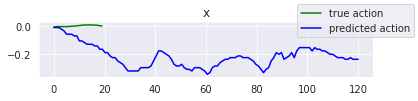

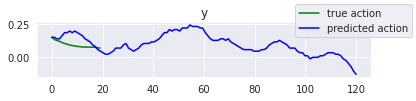

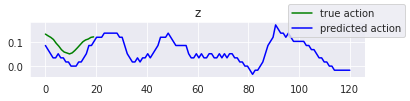

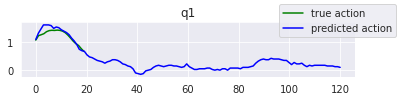

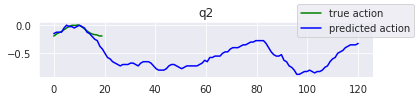

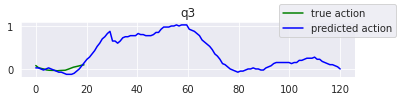

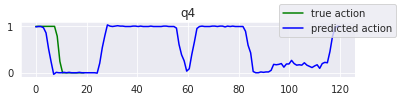

In [45]:
length_true = len(true)
length_pred = len(pred)
actions_space = true.shape[-1]
x_true = np.linspace(0, length_true, num=length_true) 
x_pred = np.linspace(0, length_pred, num=length_pred) 
if JOINTS:
    labels = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'gripper']
else:
    labels = ['x','y','z','q1','q2','q3','q4','gripper']
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(6,1.0), squeeze=False)
    # One Model
    axes[0,0].plot(x_true,true[:,i],'green')
    axes[0,0].plot(x_pred,pred[:,i], 'b')
    fig.legend( ('true action', 'predicted action'))
   
    plt.title(labels[i])
    plt.show()

In [105]:
state_evolve = np.squeeze(np.array(states))

In [106]:
sns.heatmap(state_evolve.T)

ValueError: Must pass 2-d input

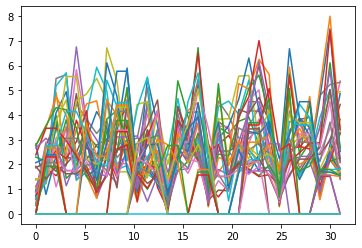

In [107]:
plt.plot(np.linspace(0,len(states)-1,len(states)-1),np.linalg.norm(state_evolve[1:,:] - state_evolve[:-1,:], axis=-1))

In [28]:

for i in range(0,20):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    true, pred, _ = test_subsequences(data, idx, retries = 1, replay=True)
    #true, pred, states = test_subsequences(data, idx, retries = 1, replay=False)

7 3085
73085
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3085.bullet
7 3008
73008
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3008.bullet
7 3034
73034
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3034.bullet
7 3169
73169
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3169.bullet
7 2984
72984
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2984.bullet
7 2969
72969
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2969.bullet
7 3250
73250
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3250.bullet
7 3272
73272
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3272.bullet
7 3267
73267
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3267.bullet
7 3206
73206
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3206.bullet


# Transition Model Experiments

In [18]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False}
if PROBABILISTIC:
    actor_stateful = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor_stateful = create_actor(**model_params, GCBC=GCBC)

In [28]:
%%time
actor_stateful.set_weights(actor.get_weights())

CPU times: user 530 ms, sys: 220 ms, total: 751 ms
Wall time: 370 ms


In [28]:
# Create a transition model, input obs, act, output obs
import tensorflow_addons as tfa

def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

def make_model_batch(states, acts):
    s = states[:, :-1,:]
    a = acts[:, :-1, :]
    s_next = states[:, 1:, :]
    B,T,D = s.shape
    s = tf.reshape(s, (B*T, D))
    a = tf.reshape(a, (B*T, -1))
    s_next = tf.reshape(s_next, (B*T, D))
    return s, a, s_next


model = create_transition_model()
model_optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=1e-4)
t_it = iter(train_dataset.repeat(-1))
v_it = iter(valid_dataset.repeat(-1))


In [29]:

# Take a batch from t_it, regress next obs to obs/act


total_steps = 10000
t = 0
steps = []
t_losses = []
v_losses = []
   
    
def step(d):
    s,a, _,_,_,_,_ = [d[k] for k in d.keys()]
    s,a,s_next = make_model_batch(s,a)
    s_pred = model((s,a))
    return tf.reduce_mean(tf.keras.losses.MAE(s_next, s_pred))

def train_step():
    with tf.GradientTape() as tape:
        d = t_it.next()
        loss = step(d)
        gradients = tape.gradient(loss, model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def valid_step():
    d = v_it.next()
    return step(d)


while(t<total_steps):
    
    t_loss = train_step()
    v_loss = valid_step()
    if t % 500 == 0:
        t_losses.append(t_loss)
        v_losses.append(v_loss)
        steps.append(t)
        print(t, v_loss.numpy())
        
    t += 1

0 0.2616796
500 0.08140578
1000 0.080035
1500 0.07606537
2000 0.063986965
2500 0.06395352
3000 0.061576404
3500 0.06351275


KeyboardInterrupt: 

In [30]:
def plot(array):
    plt.plot(np.linspace(0,len(array),len(array)),np.linalg.norm(array, axis=-1))

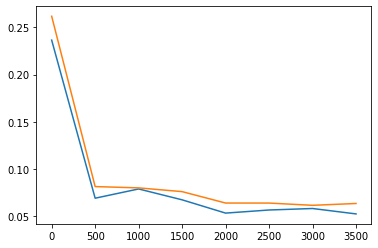

In [31]:
plt.plot(steps, t_losses)
plt.plot(steps, v_losses)

In [55]:


# Using stateful actor, play out a sequence from our trajectory bank
import time

def test_subsequences(data, idx, retries = 3, replay=False, replan_interval=20):
    
    
    states, acts, goals, seq_lens, masks, pth, tsteps = [data[k] for k in data.keys()]
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')

    env.p.restoreState(fileName=PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    state = env.panda.calc_state()
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([state['observation'], state['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(state['observation'],0),0)
    #print(states)
    #print(o.shape, o_p.shape, states.shape)
    #print(o, '-------------------', o_p)
    goal = goals[idx, traj_end,:]
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(state['velocity'],tf.float32),0),0)], axis = -1)
    
    if replay:
        retries = 1
    o_p = tf.expand_dims(tf.expand_dims(states[idx,0],0),0)
    a_true =  acts[idx, :traj_end]
    a_pred = []
    o_ins, a_ins = [],[]
    o_trues = []
    o_preds= []
    o_pred = tf.squeeze(o,0)
    for j in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        if not replay:
            replan_horizon = traj_end
        else:
            replan_horizon = traj_end
            
        for i in range(0, replan_horizon):

            
            if GCBC:
                a,_,_ = actor((o, goal))
                a = a.numpy().squeeze()
                a_pred.append(a)
            else:
                a = actor((o, z,goal)).numpy().squeeze()
                a_pred.append(a)
                
            if replay or i < 0:
                a=a_true[i, :] # test whether a good init state would help by visualising the first 5 steps
            
#             o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
#             o_pred = model((tf.squeeze(o,0),tf.expand_dims(a,0)))
            o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
            o_pred = model((o_pred,tf.expand_dims(a,0)))

            env.visualise_sub_goal(np.squeeze(o_pred))
            o, r, d, _ = env.step(a)
            vel= tf.expand_dims(tf.expand_dims(tf.cast(o['velocity'],tf.float32),0),0)
            if JOINTS:
                o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints'][:7]]), 0),0)
            else:
                o = tf.expand_dims(tf.expand_dims(o['observation'], 0),0)
                
            if VELOCITY:
                o = tf.concat([tf.cast(o, tf.float32),vel], axis = -1)
                
            o_preds.append(o_pred.numpy())
            o_trues.append(o.numpy())
            
    return np.array(a_true), np.array(a_pred), np.squeeze(np.array(o_trues)), np.squeeze(np.array(o_preds)), np.array(o_ins), np.array(a_ins)
# Feed the actions through transition model and take a few gradient steps until it was more like what actually happened

# Take loss between model predicted state and desired state for all steps, update our actor

# rerun, if its better, then update the main model, otherwise, reset this one to main



In [59]:
env.visualise_sub_goal(np.squeeze(o_pred))
env.panda.delete_sub_goal()
env.panda.sub_goals=None

In [51]:
data = t_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

In [60]:
true, pred, o_true, o_pred, o_in, a_in = test_subsequences(data, idx, retries = 1, replay=True)
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(o_pred))))

16 4709
164709
data_collection/collected_data/one_obj_play/states_and_ims/16/env_states/4709.bullet
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18


In [42]:
pred_diffs

array([[1.33662634e-02, 9.50123370e-03, 8.20809603e-03, 2.92086601e-03,
        2.78563425e-02, 1.86027586e-03, 7.22116232e-03, 8.85668769e-03,
        1.79850720e-02, 9.79271531e-03, 4.73928452e-03, 1.24136209e-02,
        5.39344549e-03, 1.91547275e-02, 8.27729702e-04, 9.51879844e-03,
        1.76945329e-02, 1.04417559e-02, 7.15146679e-03, 1.40375435e-01,
        1.01133101e-02, 4.39243138e-01, 6.38005733e-01, 3.39920908e-01,
        1.72276512e-01],
       [2.40480099e-02, 9.75231826e-03, 1.86058283e-02, 3.43033671e-03,
        2.56024897e-02, 1.98885500e-02, 6.10744953e-03, 8.42196867e-03,
        1.43989362e-02, 2.14907825e-02, 4.93970513e-03, 4.52691317e-03,
        1.65122747e-02, 2.27601528e-02, 4.68754768e-03, 9.96239483e-04,
        1.74840987e-02, 1.55081879e-02, 5.45195583e-03, 6.03234880e-02,
        1.52027667e-01, 5.31375110e-02, 1.43086195e+00, 1.01110697e+00,
        7.75173366e-01],
       [1.15349442e-02, 5.93468547e-04, 1.58793777e-02, 1.01437271e-02,
        1.5622

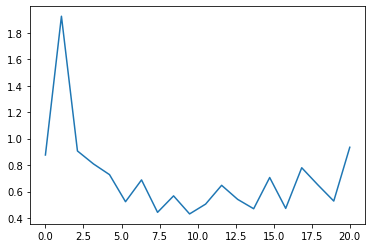

In [43]:
plot(pred_diffs)

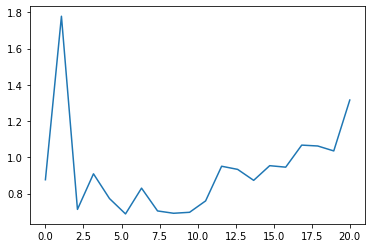

In [44]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)

In [462]:
# now, optimize the model so that it is better here
def model_update_step(o_in, a_in, o_true):
    with tf.GradientTape() as tape:
        o_pred = model((np.squeeze(o_in),np.squeeze(a_in)))
        print(o_pred.shape, o_true.shape)
        loss_time_wise = tf.keras.losses.MAE(o_pred, o_true)
        
        gradients = tape.gradient(tf.reduce_mean(loss_time_wise), model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_time_wise

In [472]:
np.array(simulated_o[:-1]).shape, a_in.shape, o_true.shape

((29, 1, 26), (30, 1, 8), (30, 26))

(30, 26) (30, 26)


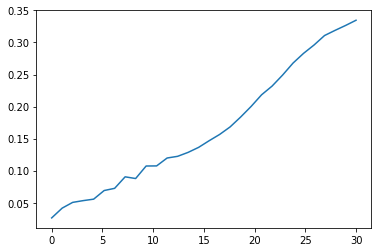

In [475]:
error = model_update_step(np.array(simulated_o),a_in, o_true)
plt.plot(np.linspace(0,len(error),len(error)),error)

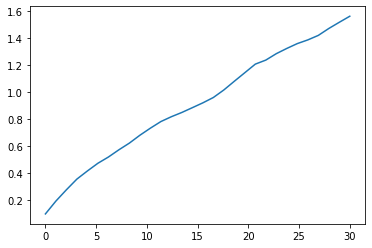

In [476]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

In [ ]:

def quat_sign_flip(a):
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = a[i-1,3:7]
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
             a[i,3:7] = - a[i,3:7]
    return a 


# Q Value function tests

In [ ]:
def create_q_function(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)


In [ ]:
# If we do it with a value function
# Discount rewards back through it - maybe using the parallelism guys thing
# then directly use AWR

# If we do it with Q... harder due to LSTM?

# Q values from (s_D, a_D, g_D)
# R from r
# Q' from nn which predicts Pi' from all s 1:,
# 

In [391]:
error

<tf.Tensor: shape=(21,), dtype=float64, numpy=
array([0.12393562, 0.01049713, 0.01037328, 0.01053249, 0.01017937,
       0.00907761, 0.00964357, 0.00983047, 0.00876082, 0.00849668,
       0.00855127, 0.00843039, 0.0092276 , 0.00918092, 0.009084  ,
       0.00929162, 0.01172736, 0.0116516 , 0.01150378, 0.00865179,
       0.00925565])>

In [16]:

import pybullet as p

def create_rpy(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    rpys = []
    for i in range(len(a)):
        rpys.append(p.getEulerFromQuaternion(a[i,3:7]))
    xyz = a[:,0:3]
    rpy = np.array(rpys)
    g = np.expand_dims(a[:,-1],1)
    
    return np.concatenate([xyz, rpy, g], -1)
def quat_sign_flip(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    angles = [a[0,3:7]]
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = angles[-1] 
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
            angles.append(-quat)
        else:
            angles.append(quat)
        #print(np.sign(quat), np.sign(last_quat), (np.sign(quat)== -np.sign(last_quat)).all())
    
    #print(xyz.shape, q.shape, g.shape,q)
    return np.concatenate([xyz, q, g], -1)


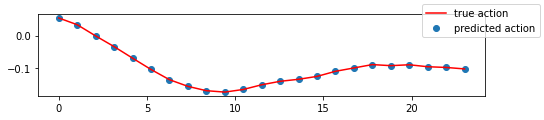

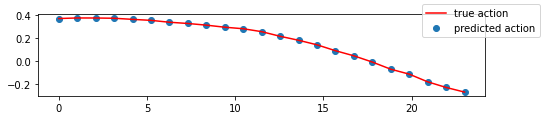

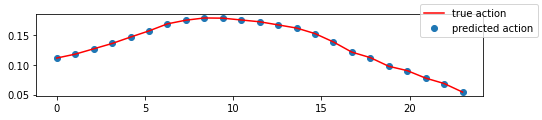

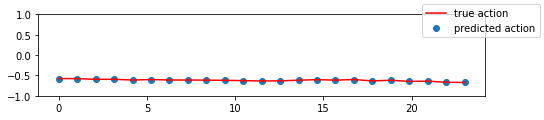

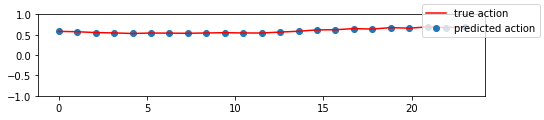

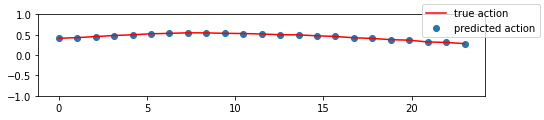

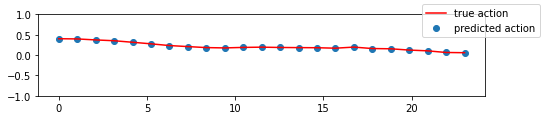

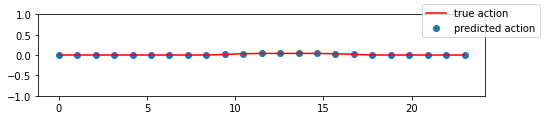

In [19]:

#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 15

length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,8):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    if i >= 3and i < 8:
        axes[0,0].set_ylim([-1,1])
    true = axes[0,0].plot(x,quat_sign_flip(acts,idx)[:,i],'r')
    #predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    #enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')
    true = axes[0,0].scatter(x,quat_sign_flip(acts,idx)[:,i])
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

In [ ]:
descriptions = {
    1: 'lift up',
    2: 'take down',
    3: 'door left',
    4: 'door right',
    5: 'drawer in',
    6: 'drawer out',
    7: 'pick place',
    8: 'press button',
    9: 'dial on',
    10: 'dial off',
    11: 'rotate block left',
    12: 'rotate block right',
    13: 'stand up block',
    14: 'knock down block',
    15: 'block in cupboard right',
    16: 'block in cupboard left',
    17: 'block in drawer',
    18: 'block out of drawer',
    19: 'block out of cupboard right',
    20: 'block out of cupboard left'
}